<a href="https://colab.research.google.com/github/mehrarishab/image_classification/blob/main/Covid19_LungInfection_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connect to Google Drive to Pull the Label Image Datasets
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/datasets/COVID_IEEE

covid  normal  virus


In [ ]:
# Installing SCIKERAS for Hyper Parameter Tunning
!pip install scikeras

In [ ]:
# Import Required Libraries
import os
import pathlib
import random
import cv2
import numpy as np
import pandas as pd
import time
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Dense
import tensorflow as tf
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
tf.keras.backend.clear_session()

In [ ]:
#Take the Count of Total Number of Samples for each Class
ds_path = '/content/drive/MyDrive/datasets/COVID_IEEE/*'

for dir in glob.glob(ds_path):
  classname = dir.split('/')[-1]
  files = os.listdir(dir)
  i = 0
  for file in files:
    i+=1
  print(f'Total Traing Sample for class: {classname} is {i}')

Total Traing Sample for class: normal is 668
Total Traing Sample for class: virus is 619
Total Traing Sample for class: covid is 536


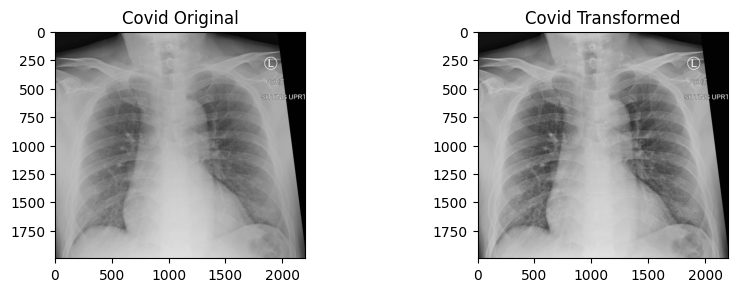

<Figure size 1000x1000 with 0 Axes>

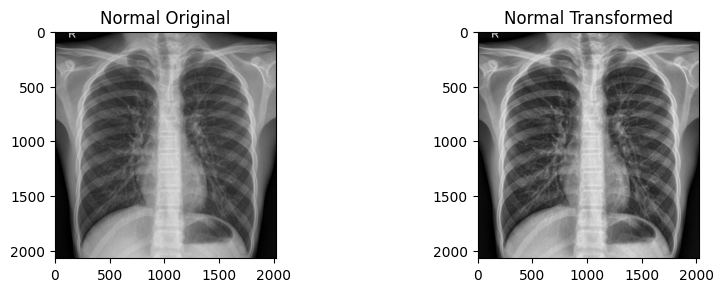

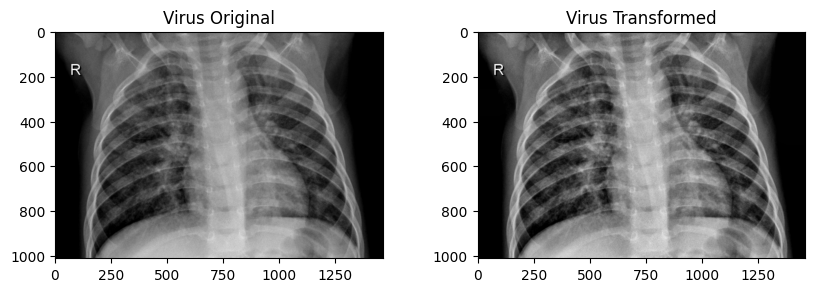

In [ ]:
# Apply Image Enhancement using CLAHE and run a Comparison with the Original Image for each Class
plt.figure(figsize=(10,10))

image1 = cv2.imread('/content/drive/MyDrive/datasets/COVID_IEEE/covid/16654_1_1.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(3,2,1)
plt.imshow(image1, cmap='gray')
plt.title('Covid Original')


image = cv2.imread('/content/drive/MyDrive/datasets/COVID_IEEE/covid/16654_1_1.png', cv2.IMREAD_GRAYSCALE)
clahe =  cv2.createCLAHE(clipLimit=0.7)
clahe_image = clahe.apply(image)
plt.subplot(3,2,2)
plt.imshow(clahe_image, cmap='gray')
plt.title('Covid Transformed')
plt.show()
plt.figure(figsize=(10,10))

plt.figure(figsize=(10,10))
image2 = cv2.imread('/content/drive/MyDrive/datasets/COVID_IEEE/normal/IM-0041-0001.jpeg', cv2.IMREAD_GRAYSCALE)
plt.subplot(3,2,3)
plt.imshow(image2, cmap='gray')
plt.title('Normal Original')


image3 = cv2.imread('/content/drive/MyDrive/datasets/COVID_IEEE/normal/IM-0041-0001.jpeg', cv2.IMREAD_GRAYSCALE)
clahe =  cv2.createCLAHE(clipLimit=0.7)
clahe_image = clahe.apply(image3)
plt.subplot(3,2,4)
plt.imshow(clahe_image, cmap='gray')
plt.title('Normal Transformed')
plt.show()

plt.figure(figsize=(10,10))
image4 = cv2.imread('/content/drive/MyDrive/datasets/COVID_IEEE/virus/person19_virus_50.jpeg', cv2.IMREAD_GRAYSCALE)
plt.subplot(3,2,5)
plt.imshow(image4, cmap='gray')
plt.title('Virus Original')


image5 = cv2.imread('/content/drive/MyDrive/datasets/COVID_IEEE/virus/person19_virus_50.jpeg', cv2.IMREAD_GRAYSCALE)
clahe =  cv2.createCLAHE(clipLimit=0.7)
clahe_image = clahe.apply(image5)
plt.subplot(3,2,6)
plt.imshow(clahe_image, cmap='gray')
plt.title('Virus Transformed')
plt.show()

In [ ]:
# Prepare Data (x,y) : Convert All Images from 3 directories (covid, normal, virus) into Numpy Array
# Use Image Enhancment method CLAHE to amplify Image contrast
# Resize the Image to size [224 x 224 x 3]

data = []
labels =[]
cat = -1
data_source = ['/content/drive/MyDrive/datasets/COVID_IEEE/covid','/content/drive/MyDrive/datasets/COVID_IEEE/normal','/content/drive/MyDrive/datasets/COVID_IEEE/virus']

clahe =  cv2.createCLAHE(clipLimit=0.7)
for ds in data_source:
  image_files = os.listdir(ds)
  cat +=1
  for file in image_files:
    filepath = os.path.join(ds,file)
    image_arr = cv2.imread(filepath)
    color_img = image_arr
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2GRAY)
    image_arr = clahe.apply(image_arr)
    image_arr = cv2.merge([image_arr, color_img[:,:,1], color_img[:,:,2]])
    image_arr = cv2.resize(image_arr, (224,224))
    data.append(image_arr)
    labels.append(cat)


In [ ]:
# Normalize the Data to scale of 0 to 1

data = np.array(data) / 255.0
xr_labels = np.array(labels)

<ipython-input-8-d09f7c930f68>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1],  label=class_lbl, s=10, cmap="tab10")


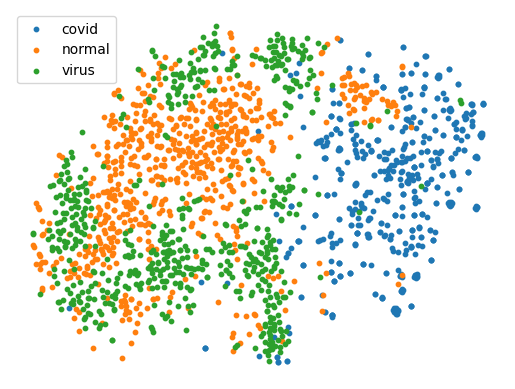

In [ ]:
# t-SNE plot depicting separability among different classes of input image data in the dataset

classes = ['covid','normal','virus']
flattened_data = data.reshape(data.shape[0],-1)
flattened_data.shape
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(flattened_data)
reduced_data.shape
for label in np.unique(xr_labels):
  indices = np.where(xr_labels == label)
  class_lbl = classes[label]
  plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1],  label=class_lbl, s=10, cmap="tab10")
plt.legend()
plt.axis("off")
plt.show()
#c=xr_labels,

In [ ]:
# Split Data into Train, Test & Validation sets using Startified Sampling

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratified_splitter.split(data, xr_labels):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = xr_labels[train_index], xr_labels[test_index]

#x_train, x_test, y_train, y_test = train_test_split(data, xr_labels, test_size=0.2, random_state=42)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, valid_index in split.split(x_train, y_train):
    x_train, x_valid = x_train[train_index], x_train[valid_index]
    y_train, y_valid = y_train[train_index], y_train[valid_index]

#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Convert Labels into One-Hot Encoded Vectors
y_train = tf.keras.utils.to_categorical(y_train , num_classes=3)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
# Print the shape of the Train & Test Data Set
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape,y_test.shape)
print(type(x_train), type(x_valid), type(x_test))


(1312, 224, 224, 3) (146, 224, 224, 3) (365, 224, 224, 3)
(1312, 3) (146, 3) (365, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
train_classes = pd.DataFrame(y_train, columns=['covid','normal','virus'])
valid_classes = pd.DataFrame(y_valid, columns=['covid','normal','virus'])
test_classes = pd.DataFrame(y_test, columns=['covid','normal','virus'])

train_classes.head()

,covid,normal,virus
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [ ]:
# Checking the Class Distribution in the Training Data Set

train_classes['covid'].value_counts(), train_classes['normal'].value_counts(), train_classes['virus'].value_counts()

(0.0    926
 1.0    386
 Name: covid, dtype: int64,
 0.0    831
 1.0    481
 Name: normal, dtype: int64,
 0.0    867
 1.0    445
 Name: virus, dtype: int64)

In [ ]:
# Checking the Class Distribution in the Test Data Set

test_classes['covid'].value_counts(), test_classes['normal'].value_counts(), test_classes['virus'].value_counts()

(0.0    258
 1.0    107
 Name: covid, dtype: int64,
 0.0    231
 1.0    134
 Name: normal, dtype: int64,
 0.0    241
 1.0    124
 Name: virus, dtype: int64)

In [ ]:
# Checking the Class Distribution in the Validation Data Set

valid_classes['covid'].value_counts(), valid_classes['normal'].value_counts(), valid_classes['virus'].value_counts()

(0.0    103
 1.0     43
 Name: covid, dtype: int64,
 0.0    93
 1.0    53
 Name: normal, dtype: int64,
 0.0    96
 1.0    50
 Name: virus, dtype: int64)

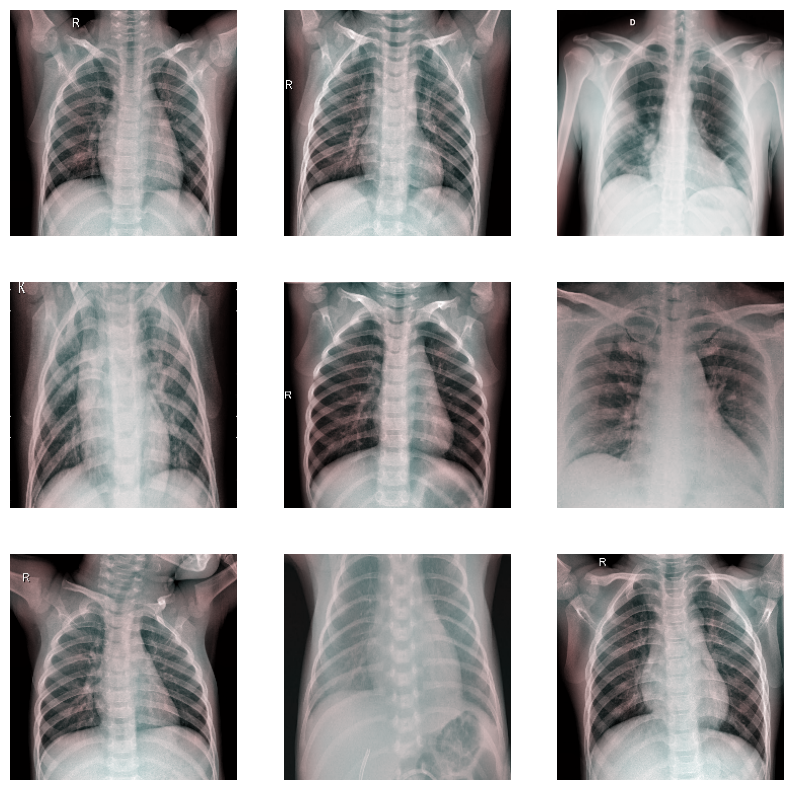

In [ ]:
# Visualize random samples from Training Data
plt.figure(figsize= (10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[i])
  plt.axis('off')
plt.show()

In [ ]:
# Create Augmented Image Data Generator
datagen = ImageDataGenerator(
    rotation_range =15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2
    #horizontal_flip = True
   # rescale = 1./255
)

In [ ]:
# Setup a Training Data Generator
train_datagen =  datagen.flow(x_train,y_train  , batch_size=32)


def data_generator():
    while True:
        augmented_data, t = next(train_datagen)
        yield augmented_data, t

dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, 3])
).repeat()


# Setup a Validation Data Generator
val_datagen = datagen.flow(x_valid,y_valid  , batch_size=32)

def data_generator_val():
    while True:
        augmented_data, t = next(val_datagen)
        yield augmented_data, t

dataset_val = tf.data.Dataset.from_generator(
    data_generator_val,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, 3])
).repeat()

In [ ]:
# Prefetch data from the dataset , it helps to overlap the data preprocessing and model execution times, which can lead to faster training

dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
#To Visualize the Augmented Data fetch one batch for each Training Samples and Validation Samples
augmented_data, t = next(train_datagen)
augmented_data_val, t_val = next(val_datagen)



In [ ]:
augmented_data = tf.data.Dataset.from_tensor_slices(augmented_data)

In [ ]:
#Check the Shape of the Augmented Data
augmented_data.shape,  t.shape , augmented_data_val.shape

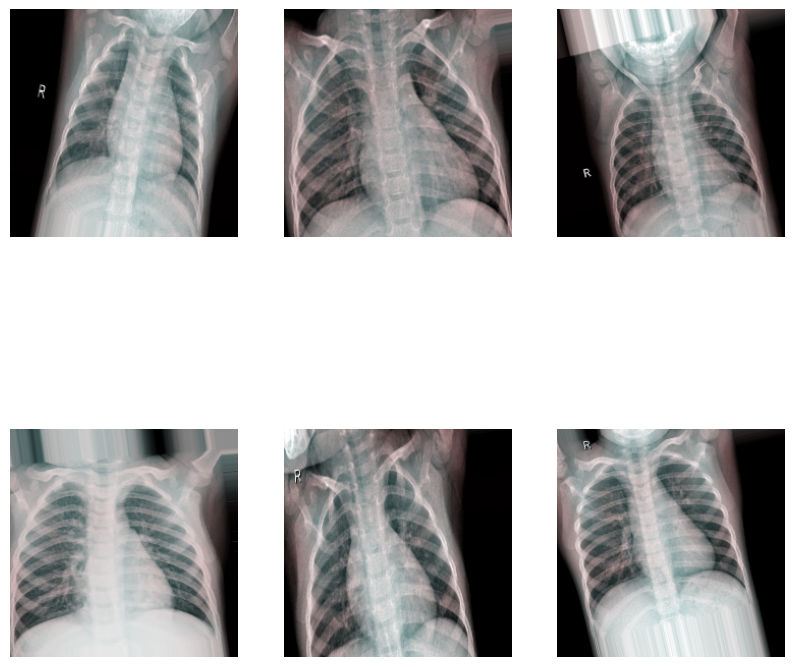

In [ ]:
# Plot the First batch Augmented Training Data
plt.figure(figsize= (10,10))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(augmented_data[i+1])
  plt.axis('off')
plt.show()

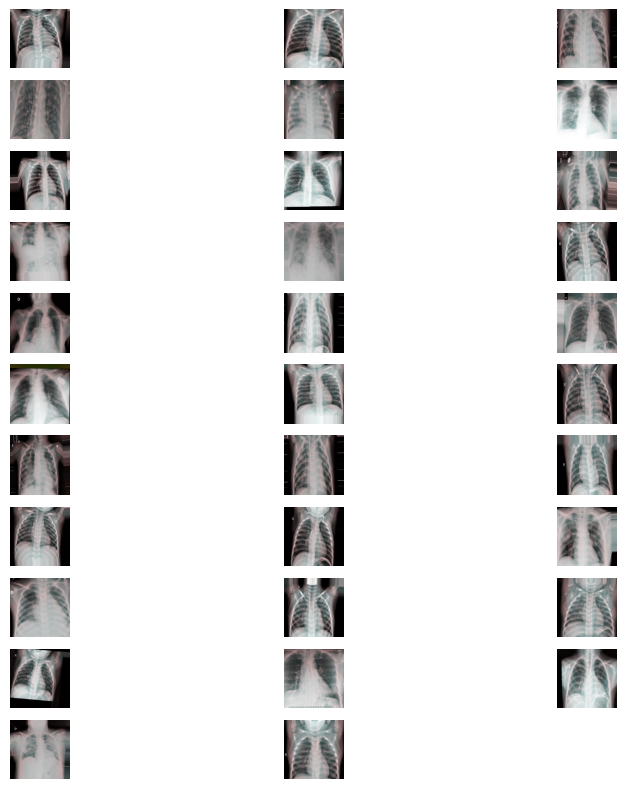

In [ ]:
# Plot the First batch Augmented Validation Data
plt.figure(figsize= (10,10))
for i in range(32):
  plt.subplot(11,3,i+1)
  plt.imshow(augmented_data_val[i])
  plt.axis('off')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Now Lets prepare the model


model = tf.keras.models.Sequential()

# CNN Layers
model.add(Conv2D(filters =16, kernel_size=(3,3), activation='relu', input_shape=[224,224,3],padding='same',strides=(1,1),kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters =32, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal',padding='same',strides=(1,1),kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters =32, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal',padding='same',strides=(1,1), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters =64, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal',padding='same',strides=(2,2),kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))


# Fully Connected Layers
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#model.add(Dense(16, activation='relu', kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128       
 chNormalization)                                                
                                                        

In [ ]:
# Setting a Learning Schedule for Early Convergence.
def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as the epoch increases.
    """
    learning_rate = 0.001

    if epoch > 5:
        learning_rate = 0.0001

    return learning_rate

lr_scheduler = LearningRateScheduler(lr_schedule)

#Define Optimizer for the Training the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)




In [ ]:
# Defining EarlyStopping CallBack
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Defining EarlyStopping CallBack
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile Model, defining the Loss function and Performance Mertices
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Train the Model on Original Dataset of 1823 Images (80% as Training Data)
history = model.fit(x_train, y_train ,  epochs=20 , batch_size=32, validation_data= (x_valid,y_valid), callbacks=[early_stopping,lr_scheduler])


In [ ]:
# Evaluate Model
model.evaluate(x_test,y_test)

12/12 [==============================] - 0s 19ms/step - loss: 1.4453 - accuracy: 0.8603


[1.4452524185180664, 0.8602739572525024]

In [ ]:
stats =  pd.DataFrame(history.history)

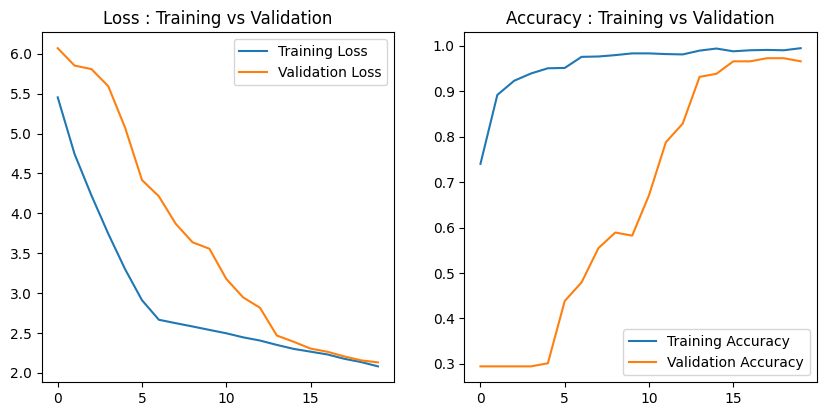

In [ ]:
# Plot the Loss & Accuracy Progression Trends while Training on Training & Validation Data

plt.figure(figsize=(10,10))
loss = stats['loss']
val_loss = stats['val_loss']
accuracy = stats['accuracy']
val_accuracy = stats['val_accuracy']

plt.subplot(2,2,1)
plt.title('Loss : Training vs Validation')
plt.plot(loss, label ='Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()

plt.subplot(2,2,2)
plt.title('Accuracy : Training vs Validation')
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Train Model on Augmented Data
# No. of Augmented Training Samples per Epoch (Steps per Epochs * Batch Size) : (64 * 32 = 2048)

history = model.fit(dataset ,steps_per_epoch=64,  epochs=25 , batch_size=32, validation_data= dataset_val,validation_steps=16, callbacks=[early_stopping,lr_scheduler])


Epoch 1/25
64/64 [==============================] - 40s 540ms/step - loss: 4.7692 - accuracy: 0.8252 - val_loss: 5.7146 - val_accuracy: 0.5255 - lr: 0.0010
Epoch 2/25
64/64 [==============================] - 35s 547ms/step - loss: 3.8888 - accuracy: 0.8975 - val_loss: 5.2655 - val_accuracy: 0.4723 - lr: 0.0010
Epoch 3/25
64/64 [==============================] - 33s 527ms/step - loss: 3.1881 - accuracy: 0.9087 - val_loss: 4.2985 - val_accuracy: 0.4978 - lr: 0.0010
Epoch 4/25
64/64 [==============================] - 43s 680ms/step - loss: 2.6233 - accuracy: 0.9170 - val_loss: 3.8905 - val_accuracy: 0.5894 - lr: 0.0010
Epoch 5/25
64/64 [==============================] - 41s 644ms/step - loss: 2.1673 - accuracy: 0.9165 - val_loss: 3.1690 - val_accuracy: 0.4681 - lr: 0.0010
Epoch 6/25
64/64 [==============================] - 34s 532ms/step - loss: 1.7473 - accuracy: 0.9375 - val_loss: 3.3239 - val_accuracy: 0.5170 - lr: 0.0010
Epoch 7/25
64/64 [==============================] - 24s 388ms/st

In [ ]:
# Evaluate the Model
model.evaluate(x_test,y_test)

12/12 [==============================] - 0s 20ms/step - loss: 1.1900 - accuracy: 0.9397


[1.1900309324264526, 0.9397260546684265]

In [ ]:
stats =  pd.DataFrame(history.history)

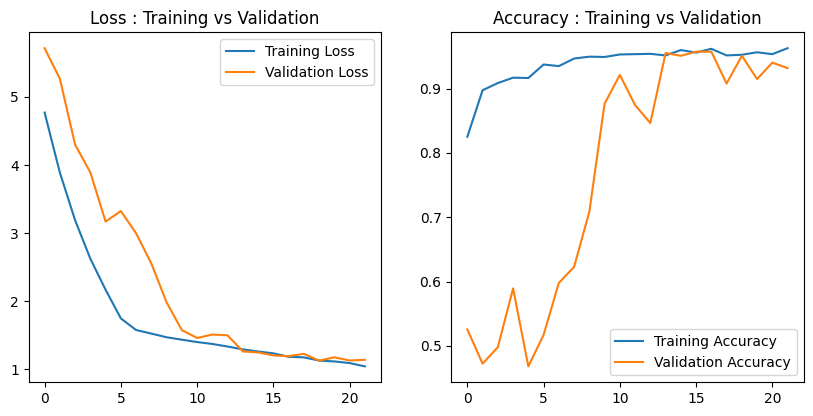

In [ ]:
# Plot the Loss & Accuracy Progression Trends while Training on Augmented Training & Validation Data
plt.figure(figsize=(10,10))
loss = stats['loss']
val_loss = stats['val_loss']
accuracy = stats['accuracy']
val_accuracy = stats['val_accuracy']

plt.subplot(2,2,1)
plt.title('Loss : Training vs Validation')
plt.plot(loss, label ='Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()

plt.subplot(2,2,2)
plt.title('Accuracy : Training vs Validation')
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()



In [ ]:
y_preds = model.predict(x_test)
preds = np.argmax(y_preds, axis=1)  # Converting Probabilites to the Predicted Class
y_test_class = np.argmax(y_test , axis=1) # Converting the One Hot Encoded Values to Class value


12/12 [==============================] - 1s 53ms/step


In [ ]:
# Generate Classification Report
print(classification_report(y_test_class, preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       107
           1       0.88      1.00      0.93       134
           2       0.99      0.85      0.91       124

    accuracy                           0.94       365
   macro avg       0.95      0.94      0.94       365
weighted avg       0.95      0.94      0.94       365



In [ ]:
# Generate Confusion matrix
pd.DataFrame(confusion_matrix(y_test_class, preds), columns=['covid','normal','virus'], index=['covid','normal','virus'])

,covid,normal,virus
covid,104,2,1
normal,0,134,0
virus,2,17,105


In [ ]:
# Save Model
model.save('/content/drive/My Drive/chest_xray_0218.keras')
model.save('/content/drive/My Drive/chest_xray_0218.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Clear Session
tf.keras.backend.clear_session()

In [ ]:
# Now Lets try some Transfer Learning
# Using MobileNetV2 Trained Model, Data Set used for Training is Image net
# Remove the last Prediction Layer of MobileNet while Loading the Model
trf_model = tf.keras.applications.MobileNet(input_shape=[224,224,3], weights='imagenet', include_top=False)


In [ ]:
# Set all the layers of MobileNet as Non Trainable
for layer in trf_model.layers:
  layer.trainable = False


In [ ]:
trf_model.summary()

In [ ]:
# Flatten the Output of last layer of MobileNet model
model1 = tf.keras.layers.Flatten()(trf_model.output)

# Fully Connected layers
model1 = tf.keras.layers.Dense(64, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01))(model1)
model1 =  tf.keras.layers.BatchNormalization()(model1)
model1 =  tf.keras.layers.Dropout(0.2)(model1)

model1 = tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01))(model1)
model1 =  tf.keras.layers.BatchNormalization()(model1)
model1 =  tf.keras.layers.Dropout(0.2)(model1)

model1 = tf.keras.layers.Dense(16, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01))(model1)
model1 =  tf.keras.layers.BatchNormalization()(model1)
model1 =  tf.keras.layers.Dropout(0.2)(model1)

inference_layer = tf.keras.layers.Dense(3, activation='softmax')(model1)



In [ ]:
# Creating Model using MobileNetV2

model1 = tf.keras.models.Model(inputs = trf_model.input, outputs=inference_layer)

# Compile Model
model1.compile(loss='categorical_crossentropy' , optimizer=optimizer, metrics=['accuracy'])

# Defining EarlyStopping CallBack
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train Model on Augmented Data
# No. of Augmented Training Samples per Epoch (Steps per Epochs * Batch Size) : (64 * 32 = 2048)
history1 = model1.fit(dataset ,steps_per_epoch=64,  epochs=25 , batch_size=32, validation_data= dataset_val,validation_steps=16, callbacks=[early_stopping,lr_scheduler])

Epoch 1/25
64/64 [==============================] - 45s 558ms/step - loss: 2.5818 - accuracy: 0.8149 - val_loss: 2.0434 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 2/25
64/64 [==============================] - 34s 541ms/step - loss: 1.6949 - accuracy: 0.9248 - val_loss: 1.4111 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 3/25
64/64 [==============================] - 32s 503ms/step - loss: 1.2944 - accuracy: 0.9331 - val_loss: 1.1353 - val_accuracy: 0.9532 - lr: 0.0010
Epoch 4/25
64/64 [==============================] - 32s 504ms/step - loss: 1.0895 - accuracy: 0.9380 - val_loss: 0.9542 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 5/25
64/64 [==============================] - 30s 473ms/step - loss: 0.8999 - accuracy: 0.9448 - val_loss: 0.9055 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 6/25
64/64 [==============================] - 30s 475ms/step - loss: 0.8553 - accuracy: 0.9424 - val_loss: 0.9113 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 7/25
64/64 [==============================] - 30s 469ms/st

In [ ]:
# Evaluate Model on test data
model1.evaluate(x_test, y_test)

12/12 [==============================] - 1s 96ms/step - loss: 0.3660 - accuracy: 0.9699


[0.36598774790763855, 0.9698629975318909]

In [ ]:
stats =  pd.DataFrame(history1.history)

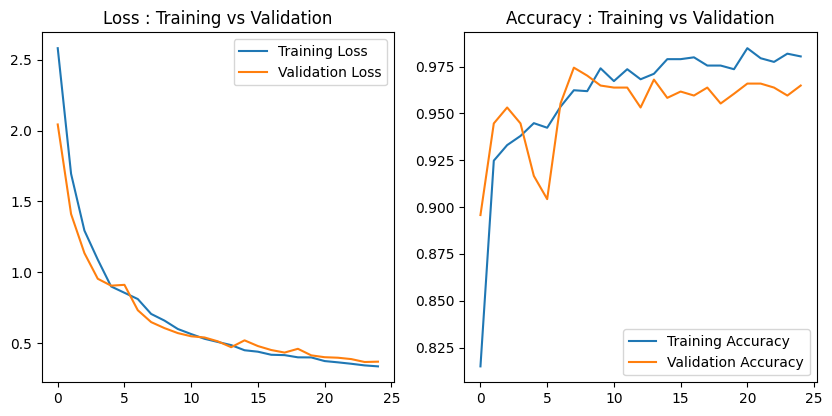

In [ ]:
# Plot the Loss & Accuracy Progression Trends while Training on Augmented Training & Validation Data
plt.figure(figsize=(10,10))
loss = stats['loss']
val_loss = stats['val_loss']
accuracy = stats['accuracy']
val_accuracy = stats['val_accuracy']

plt.subplot(2,2,1)
plt.title('Loss : Training vs Validation')
plt.plot(loss, label ='Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()

plt.subplot(2,2,2)
plt.title('Accuracy : Training vs Validation')
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
y_preds = model1.predict(x_test)
preds = np.argmax(y_preds, axis=1)  # Converting Probabilites to the Predicted Class
y_test_class = np.argmax(y_test , axis=1) # Converting the One Hot Encoded Values to Class value

12/12 [==============================] - 1s 42ms/step


In [ ]:
# Generate Classification Report
print(classification_report(y_test_class, preds))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       107
           1       0.94      1.00      0.97       134
           2       0.97      0.94      0.95       124

    accuracy                           0.97       365
   macro avg       0.97      0.97      0.97       365
weighted avg       0.97      0.97      0.97       365



In [ ]:
# Generate Confusion Matrix
pd.DataFrame(confusion_matrix(y_test_class, preds), columns=['covid','normal','virus'], index=['covid','normal','virus'])

,covid,normal,virus
covid,104,0,3
normal,0,134,0
virus,0,8,116


In [ ]:
model.save('/content/drive/My Drive/chest_xray_trf_0218.keras')
model.save('/content/drive/My Drive/chest_xray_trf_0218.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

activation = ['relu','selu','tanh']
optimizer = ['RMSprop', 'Adam','SGD']
init_weights = ['he_normal','lecun_normal']
lr = [0.0001, 0.001]
momentum = [0.3, 0.5, 0.7, 0.9]
dropout = [0.0, 0.2, 0.4]
neurons = [16,32,64,128]
epochs = [10,15,20]
filters =  [16,32,64,128]

def define_model(filters =16, activation='relu', init_weights='he_normal', lr=0.0001,input_shape=[224,224,3]):
  model = tf.keras.models.Sequential()
  #CNN Layers

  model.add(Conv2D(filters = filters, kernel_size= (3,3), input_shape=[224,224,3], activation=activation, kernel_initializer=init_weights , padding='same', strides=(1,1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(filters = filters, kernel_size= (3,3), activation=activation, kernel_initializer=init_weights , padding='same', strides=(1,1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(filters = filters, kernel_size= (3,3), activation=activation, kernel_initializer=init_weights , padding='same', strides=(1,1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(2,2))

  # Fully Connected Layers
  model.add(Flatten())

  model.add(Dense(64, activation=activation, kernel_initializer=init_weights))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(32, activation=activation, kernel_initializer=init_weights))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(16, activation=activation, kernel_initializer=init_weights))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(3, activation='softmax'))

  # Define Optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
model = KerasClassifier(build_fn = define_model,
                        activation ='relu',
                        init_weights='he_normal',
                        lr=0.0001  ,
                        filters =16,
                        batch_size=32,
                        verbose=1
                        )

param_grid = dict(#lr=lr,
                  filters=filters
                  #momentum=momentum,
                  #activation=activation,
                  #init_weights=init_weights,
                 # optimizer=optimizer
                  #dropout_rate=dropout_rate,
                  #weight_constraint=weight_constraint,
                  #neurons=neurons
                  )

clf = GridSearchCV(estimator=model, param_grid= param_grid, cv=4)

clf_results = clf.fit(x_train, y_train ,  epochs=10 , batch_size=32, callbacks=[early_stopping,lr_scheduler])


In [ ]:
print("Best: %f using %s" % (clf_results.best_score_, clf_results.best_params_))


In [ ]:
# Take the Count of Total Number of Samples for each Class

ds_path = '/content/drive/MyDrive/datasets/covid_dataset/*'

for dir in glob.glob(ds_path):
  classname = dir.split('/')[-1]
  files = os.listdir(dir)
  i = 0
  for file in files:
    i+=1
  print(f'Total Traing Sample for class: {classname} is {i}')

Total Traing Sample for class: normal is 8882
Total Traing Sample for class: virus is 5984
Total Traing Sample for class: covid is 9281


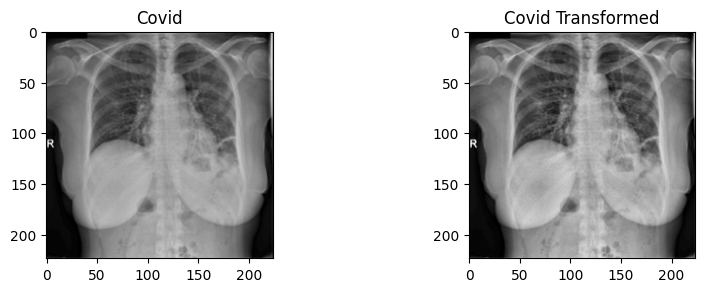

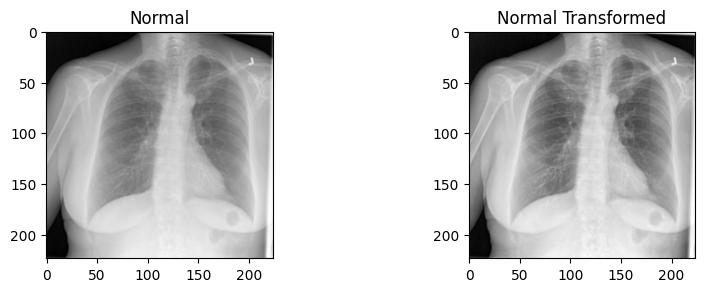

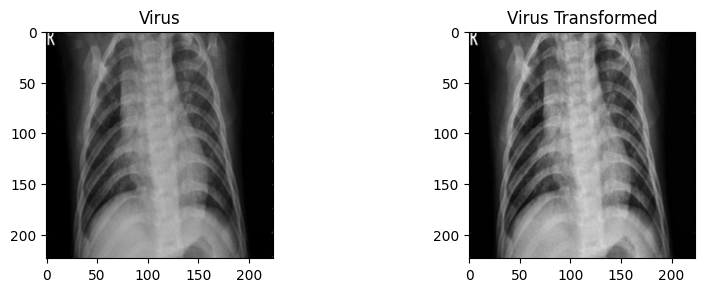

In [ ]:
# Apply Image Enhancement using CLAHE and run a Comparison with the Original Image for each Class

plt.figure(figsize=(10,10))

image1 = cv2.imread('/content/drive/MyDrive/datasets/covid_dataset/covid/47.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(3,2,1)
plt.imshow(image1, cmap='gray')
plt.title('Covid')


image = cv2.imread('/content/drive/MyDrive/datasets/covid_dataset/covid/47.png', cv2.IMREAD_GRAYSCALE)
clahe =  cv2.createCLAHE(clipLimit=0.7)
clahe_image = clahe.apply(image)
plt.subplot(3,2,2)
plt.imshow(clahe_image, cmap='gray')
plt.title('Covid Transformed')
plt.show()

plt.figure(figsize=(10,10))
image2 = cv2.imread('/content/drive/MyDrive/datasets/covid_dataset/normal/21805.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(3,2,3)
plt.imshow(image2, cmap='gray')
plt.title('Normal')


image3 = cv2.imread('/content/drive/MyDrive/datasets/covid_dataset/normal/21805.png', cv2.IMREAD_GRAYSCALE)
clahe =  cv2.createCLAHE(clipLimit=0.7)
clahe_image = clahe.apply(image3)
plt.subplot(3,2,4)
plt.imshow(clahe_image, cmap='gray')
plt.title('Normal Transformed')
plt.show()

plt.figure(figsize=(10,10))
image4 = cv2.imread('/content/drive/MyDrive/datasets/covid_dataset/virus/16463.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(3,2,5)
plt.imshow(image4, cmap='gray')
plt.title('Virus')


image5 = cv2.imread('/content/drive/MyDrive/datasets/covid_dataset/virus/16463.png', cv2.IMREAD_GRAYSCALE)
clahe =  cv2.createCLAHE(clipLimit=0.7)
clahe_image = clahe.apply(image5)
plt.subplot(3,2,6)
plt.imshow(clahe_image, cmap='gray')
plt.title('Virus Transformed')
plt.show()

In [ ]:
# Prepare Data (x,y) : Convert All Images from 3 directories (covid, normal, virus) into Numpy Array
# Use Image Enhancment method CLAHE to amplify Image contrast
# Resize the Image to size [224 x 224 x 3]

data = []
labels =[]
cat = -1
data_source = ['/content/drive/MyDrive/datasets/covid_dataset/covid','/content/drive/MyDrive/datasets/covid_dataset/normal','/content/drive/MyDrive/datasets/covid_dataset/virus']

clahe =  cv2.createCLAHE(clipLimit=0.7)
for ds in data_source:
  image_files = os.listdir(ds)
  cat +=1
  for file in image_files[:3500]:
    filepath = os.path.join(ds,file)
    image_arr = cv2.imread(filepath)
    color_img = image_arr
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2GRAY)
    image_arr = clahe.apply(image_arr)
    image_arr = cv2.merge([image_arr, color_img[:,:,1], color_img[:,:,2]])
    image_arr = cv2.resize(image_arr, (224,224))
    data.append(image_arr)
    labels.append(cat)


In [ ]:
# Normalize the Data to scale of 0 to 1

data = np.array(data) / 255.0
xr_labels = np.array(labels)

In [ ]:
# Prepare Training, Validation & Test Data

# Training & Testing Data Split
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratified_splitter.split(data, xr_labels):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = xr_labels[train_index], xr_labels[test_index]


# Training & Validation Data Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, valid_index in split.split(x_train, y_train):
    x_train, x_valid = x_train[train_index], x_train[valid_index]
    y_train, y_valid = y_train[train_index], y_train[valid_index]




y_train = tf.keras.utils.to_categorical(y_train , num_classes=3)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
# Print the shape of the Train & Test Data Set
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape,y_test.shape)

(7140, 224, 224, 3) (1260, 224, 224, 3) (2100, 224, 224, 3)
(7140, 3) (1260, 3) (2100, 3)


In [ ]:
train_classes = pd.DataFrame(y_train, columns=['covid','normal','virus'])
valid_classes = pd.DataFrame(y_valid, columns=['covid','normal','virus'])
test_classes = pd.DataFrame(y_test, columns=['covid','normal','virus'])

train_classes.head()

,covid,normal,virus
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0


In [ ]:
# Checking the Class Distribution in the Training Data Set
train_classes['covid'].value_counts(), train_classes['normal'].value_counts(), train_classes['virus'].value_counts()

(0.0    4760
 1.0    2380
 Name: covid, dtype: int64,
 0.0    4760
 1.0    2380
 Name: normal, dtype: int64,
 0.0    4760
 1.0    2380
 Name: virus, dtype: int64)

In [ ]:
# Checking the Class Distribution in the Test Data Set
test_classes['covid'].value_counts(), test_classes['normal'].value_counts(), test_classes['virus'].value_counts()

(0.0    1400
 1.0     700
 Name: covid, dtype: int64,
 0.0    1400
 1.0     700
 Name: normal, dtype: int64,
 0.0    1400
 1.0     700
 Name: virus, dtype: int64)

In [ ]:
# Checking the Class Distribution in the Validation Data Set
valid_classes['covid'].value_counts(), valid_classes['normal'].value_counts(), valid_classes['virus'].value_counts()

(0.0    840
 1.0    420
 Name: covid, dtype: int64,
 0.0    840
 1.0    420
 Name: normal, dtype: int64,
 0.0    840
 1.0    420
 Name: virus, dtype: int64)

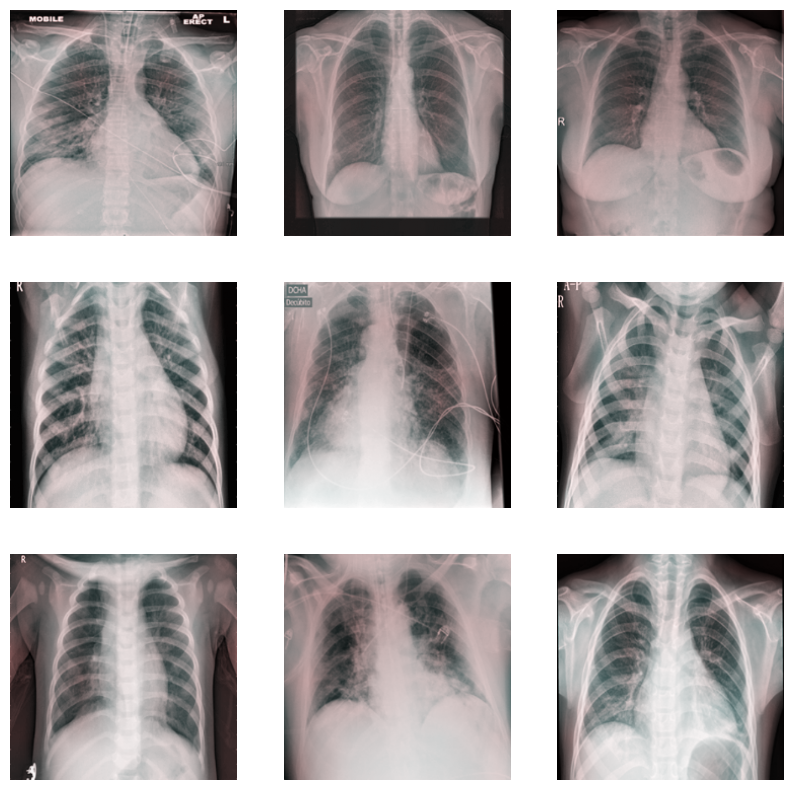

In [ ]:
# Visualize random samples from Training Data
plt.figure(figsize= (10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[i])
  #plt.title(y_train[i])
  plt.axis('off')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Now Lets prepare the model


modelB = tf.keras.models.Sequential()

# CNN Layers
modelB.add(Conv2D(filters =16, kernel_size=(3,3), activation='relu', input_shape=[224,224,3],padding='same',strides=(1,1)))
modelB.add(BatchNormalization())
modelB.add(MaxPool2D(2,2))

modelB.add(Conv2D(filters =32, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal',padding='same',strides=(1,1),kernel_regularizer=regularizers.l2(0.01)))
modelB.add(BatchNormalization())
modelB.add(MaxPool2D(2,2))

modelB.add(Conv2D(filters =32, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal',padding='same',strides=(1,1), kernel_regularizer=regularizers.l2(0.01)))
modelB.add(BatchNormalization())
modelB.add(MaxPool2D(2,2))

modelB.add(Conv2D(filters =64, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal',padding='same',strides=(2,2),kernel_regularizer=regularizers.l2(0.01)))
modelB.add(BatchNormalization())
modelB.add(MaxPool2D(2,2))


# Fully Connected Layers
modelB.add(Flatten())
modelB.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.2))

modelB.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.2))

modelB.add(Dense(3, activation='softmax'))

In [ ]:
# Setting a Learning Schedule for Early Convergence.

def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as the epoch increases.
    """
    learning_rate = 0.001
    if epoch > 7:
        learning_rate = 0.0001
    return learning_rate



lr_scheduler = LearningRateScheduler(lr_schedule)

# Setup Training Optimizer, using ADAM here
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
modelB.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Defining EarlyStopping CallBack

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train Model on this large Data set
# No. of Training Samples per Epoch (Steps per Epochs * Batch Size) : (112 * 64 = 7168)

historyB = modelB.fit(x_train, y_train, validation_data= (x_valid,y_valid), epochs=20 , batch_size=64, callbacks=[early_stopping,lr_scheduler])

Epoch 1/20
112/112 [==============================] - 21s 100ms/step - loss: 4.2885 - accuracy: 0.8373 - val_loss: 4.5023 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
112/112 [==============================] - 7s 66ms/step - loss: 2.6778 - accuracy: 0.9291 - val_loss: 4.2486 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
112/112 [==============================] - 7s 67ms/step - loss: 1.7307 - accuracy: 0.9461 - val_loss: 3.3160 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 4/20
112/112 [==============================] - 7s 66ms/step - loss: 1.2196 - accuracy: 0.9500 - val_loss: 2.3687 - val_accuracy: 0.4730 - lr: 0.0010
Epoch 5/20
112/112 [==============================] - 7s 66ms/step - loss: 0.9033 - accuracy: 0.9566 - val_loss: 2.0214 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 6/20
112/112 [==============================] - 7s 67ms/step - loss: 0.7221 - accuracy: 0.9564 - val_loss: 0.9928 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 7/20
112/112 [==============================] - 7s 67ms/

In [ ]:
# Evaluate the Model
modelB.evaluate(x_test,y_test)

66/66 [==============================] - 2s 16ms/step - loss: 0.2499 - accuracy: 0.9795


[0.24993866682052612, 0.9795238375663757]

In [ ]:
stats =  pd.DataFrame(historyB.history)

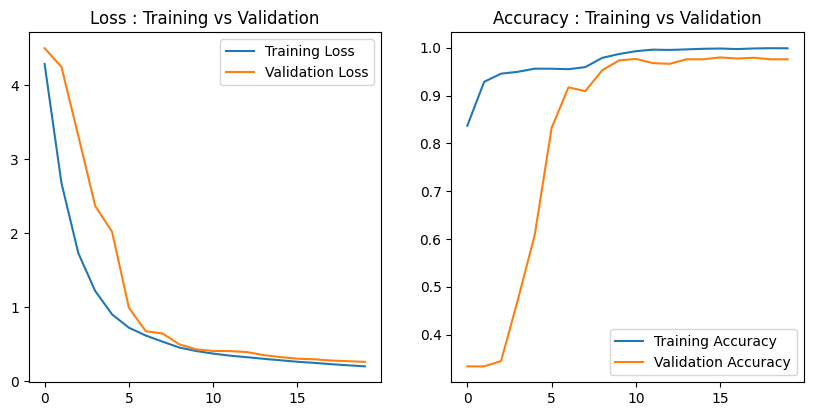

In [ ]:
# Plot the Loss & Accuracy Progression Trends while Training on Augmented Training & Validation Data
plt.figure(figsize=(10,10))
loss = stats['loss']
val_loss = stats['val_loss']
accuracy = stats['accuracy']
val_accuracy = stats['val_accuracy']

plt.subplot(2,2,1)
plt.title('Loss : Training vs Validation')
plt.plot(loss, label ='Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()

plt.subplot(2,2,2)
plt.title('Accuracy : Training vs Validation')
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
y_preds = modelB.predict(x_test)
preds = np.argmax(y_preds, axis=1)  # Converting Probabilites to the Predicted Class
y_test_class = np.argmax(y_test , axis=1) # Converting the One Hot Encoded Values to Class value

66/66 [==============================] - 1s 12ms/step


In [ ]:
# Generate Classification Report
print(classification_report(y_test_class, preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       700
           1       0.98      0.97      0.97       700
           2       0.99      0.99      0.99       700

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100



In [ ]:
# Generate Confusion matrix
pd.DataFrame(confusion_matrix(y_test_class, preds), columns=['covid','normal','virus'], index=['covid','normal','virus'])

,covid,normal,virus
covid,684,14,2
normal,16,678,6
virus,3,2,695


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Now Lets try some Transfer Learning
# Using MobileNetV2 Trained Model, Data Set used for Training is Image net
# Remove the last Prediction Layer of MobileNet while Loading the Model

trf_model = tf.keras.applications.MobileNet(input_shape=[224,224,3], weights='imagenet', include_top=False)

In [ ]:
# Set all the layers of MobileNet as Non Trainable
for layer in trf_model.layers:
  layer.trainable = False

In [ ]:
trf_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
# Flatten the Output of last layer of MobileNet model
modelC = tf.keras.layers.Flatten()(trf_model.output)

# Fully Connected layers
modelC = tf.keras.layers.Dense(64, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01))(modelC)
modelC = tf.keras.layers.BatchNormalization()(modelC)
modelC = tf.keras.layers.Dropout(0.2)(modelC)

modelC = tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01))(modelC)
modelC = tf.keras.layers.BatchNormalization()(modelC)
modelC = tf.keras.layers.Dropout(0.2)(modelC)

modelC = tf.keras.layers.Dense(16, activation='relu',kernel_initializer='he_normal')(modelC)
modelC = tf.keras.layers.BatchNormalization()(modelC)
modelC = tf.keras.layers.Dropout(0.2)(modelC)

inference_layer = tf.keras.layers.Dense(3, activation='softmax')(modelC)

In [ ]:
# Head of the Model is Inference Layer which Predicts
# Model setup via Transfer Learning will take the input

modelC = tf.keras.models.Model(inputs = trf_model.input, outputs=inference_layer)

# Compile Model
modelC.compile(loss='categorical_crossentropy' , optimizer=optimizer, metrics=['accuracy'])


In [ ]:
# Setting a Learning Schedule for Early Convergence.

def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as the epoch increases.
    """
    learning_rate = 0.001
    if epoch > 3:
        learning_rate = 0.0001
    return learning_rate

lr_scheduler = LearningRateScheduler(lr_schedule)

# Setup Training Optimizer, using ADAM here
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train Model on this large Data set
# No. of Training Samples per Epoch (Steps per Epochs * Batch Size) : (112 * 64 = 7168)
historyC = modelC.fit(x_train, y_train, validation_data= (x_valid,y_valid), epochs=20, batch_size=64 , callbacks=[early_stopping,lr_scheduler])

Epoch 1/20
112/112 [==============================] - 22s 121ms/step - loss: 1.7956 - accuracy: 0.8735 - val_loss: 1.1080 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 2/20
112/112 [==============================] - 9s 80ms/step - loss: 0.8527 - accuracy: 0.9532 - val_loss: 0.9527 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 3/20
112/112 [==============================] - 9s 81ms/step - loss: 0.6358 - accuracy: 0.9598 - val_loss: 0.6585 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 4/20
112/112 [==============================] - 9s 80ms/step - loss: 0.5189 - accuracy: 0.9639 - val_loss: 0.6825 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 5/20
112/112 [==============================] - 9s 81ms/step - loss: 0.4344 - accuracy: 0.9773 - val_loss: 0.4023 - val_accuracy: 0.9690 - lr: 1.0000e-04
Epoch 6/20
112/112 [==============================] - 9s 81ms/step - loss: 0.3274 - accuracy: 0.9889 - val_loss: 0.3176 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 7/20
112/112 [==============================] - 

In [ ]:
# Evaluate Model on test data
modelC.evaluate(x_test, y_test)

66/66 [==============================] - 4s 44ms/step - loss: 0.2174 - accuracy: 0.9829


[0.21740871667861938, 0.9828571677207947]

In [ ]:
stats =  pd.DataFrame(historyC.history)

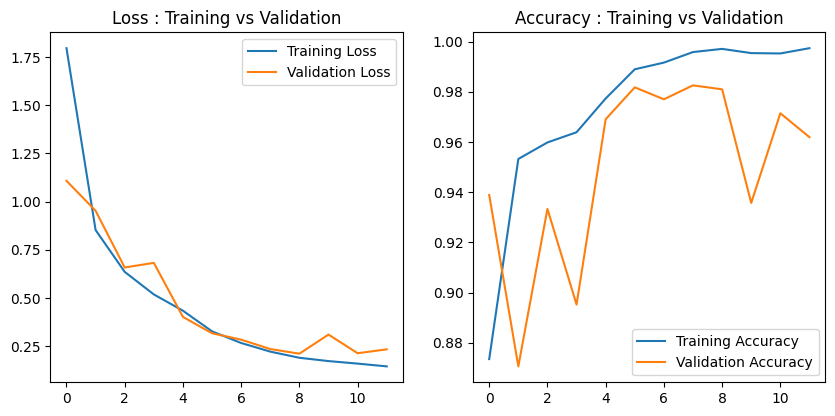

In [ ]:
# Plot the Loss & Accuracy Progression Trends while Training on Augmented Training & Validation Data

plt.figure(figsize=(10,10))
loss = stats['loss']
val_loss = stats['val_loss']
accuracy = stats['accuracy']
val_accuracy = stats['val_accuracy']

plt.subplot(2,2,1)
plt.title('Loss : Training vs Validation')
plt.plot(loss, label ='Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()

plt.subplot(2,2,2)
plt.title('Accuracy : Training vs Validation')
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
y_preds = modelC.predict(x_test)
preds = np.argmax(y_preds, axis=1)  # Converting Probabilites to the Predicted Class
y_test_class = np.argmax(y_test , axis=1) # Converting the One Hot Encoded Values to Class value

66/66 [==============================] - 3s 34ms/step


In [ ]:
# Generate Classification Report
print(classification_report(y_test_class, preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       700
           1       0.97      0.98      0.98       700
           2       0.99      1.00      0.99       700

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100



In [ ]:
# Generate Confusion matrix
pd.DataFrame(confusion_matrix(y_test_class, preds), columns=['covid','normal','virus'], index=['covid','normal','virus'])

,covid,normal,virus
covid,680,17,3
normal,11,686,3
virus,0,2,698
